https://gis.stackexchange.com/questions/350771/earth-engine-simplest-way-to-move-from-ee-image-to-array-for-use-in-sklearn

In [31]:
cd

/home/jovyan


### Setup

#### Install GEE API

In [2]:
# !pip install earthengine-api

Processing /home/jovyan/.cache/pip/wheels/9f/80/5b/e91c964b8bd337a2ac43eb6b47772465dd9f085f7e9b1b75b1/earthengine_api-0.1.226-py3-none-any.whl
  Using cached httplib2-0.18.1-py3-none-any.whl (95 kB)
  Using cached google_api_python_client-1.9.3-py3-none-any.whl (59 kB)
Processing /home/jovyan/.cache/pip/wheels/50/6c/00/2a8868de404e13a77667ff2c94e908e7cff9acd1d1dd307a48/httplib2shim-0.0.3-py2.py3-none-any.whl
  Using cached google_cloud_storage-1.29.0-py2.py3-none-any.whl (85 kB)
  Using cached google_auth_httplib2-0.0.3-py2.py3-none-any.whl (6.3 kB)
  Using cached uritemplate-3.0.1-py2.py3-none-any.whl (15 kB)
  Using cached google_api_core-1.21.0-py2.py3-none-any.whl (90 kB)
  Using cached google_cloud_core-1.3.0-py2.py3-none-any.whl (26 kB)
  Using cached google_resumable_media-0.5.1-py2.py3-none-any.whl (38 kB)
  Using cached googleapis_common_protos-1.52.0-py2.py3-none-any.whl (100 kB)
ERROR: google-api-core 1.21.0 has requirement google-auth<2.0dev,>=1.18.0, but you'll have google

#### Import modules

In [125]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import sys
import folium
import datacube

sys.path.append("Scripts")
from dea_plotting import display_map

In [126]:
dc = datacube.Datacube(app='WCF')

#### Authenticate

In [4]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AFb-SV3GTL-OhRgGj2v4XqD4FLzwTCHMr63CfNya9ue440EwC-jshs



Successfully saved authorization token.


### Define parameters 

In [76]:
# Define parameters

# Dates
# NOTE: GEE dates are inclusive and GA are exclusive on the end date
start = '2018-01-01'
end_ga = '2018-12-31'
end_gee = '2019-01-01'

# Set the central latitude and longitude
central_lat = -35.555439 
central_lon = 138.886889

In [77]:
# Set the buffer to load around the central coordinates
buffer = 0.05 # must be small for .sampleRectangle() to work

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: h

### Load GEE imagery

In [116]:
# Define an area of interest.
aoi = ee.Geometry.Polygon(
  [[[study_area_lon[0], study_area_lat[0]],
    [study_area_lon[0], study_area_lat[1]],
    [study_area_lon[1], study_area_lat[1]],
    [study_area_lon[1], study_area_lat[0]]]], None, False)

# Filter collection to get desired image
img = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")\
        .filterBounds(aoi)\
        .filterDate(start,end_gee)\
        .filter(ee.Filter.lt('CLOUD_COVER',5))\
        .select(['B4', 'B3', 'B2'])\
        .first()\

### Display GEE image in folium

Define parameters for display

In [117]:
# Map location in lats and lons
location=[central_lat,central_lon]
# How zoomed in the map is
zoom_start=10

# Image to use
image = img
# Set visualization parameters.
vis_params = {
  'bands':['B4','B3','B2'], # check which abnds here https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR#bands
  'min': 0, # pixel value
  'max': 3000 # pixel value
}
display_name = 'Sentinel 2 median'

Create custom function to display GEE image in folium map

In [118]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = "Map Data © Google Earth Engine",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer


Display your map

In [119]:
# Create a folium map object.
my_map = folium.Map(location=location, zoom_start=zoom_start, height=500)

# Add the elevation model to the map object.
my_map.add_ee_layer(img, vis_params, display_name)

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

### Convert image into a numpy array

In [120]:
img

In [121]:
# Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
band_arrs = img.sampleRectangle(region=aoi)

# Get individual band arrays.
band_arr_b4 = band_arrs.get('B2') #B2
band_arr_b5 = band_arrs.get('B3') #B3
band_arr_b6 = band_arrs.get('B4') #B4

# Transfer the arrays from server to client and cast as np array.
np_arr_b4 = np.array(band_arr_b4.getInfo())
np_arr_b5 = np.array(band_arr_b5.getInfo())
np_arr_b6 = np.array(band_arr_b6.getInfo())
print(np_arr_b4.shape)
print(np_arr_b5.shape)
print(np_arr_b6.shape)

# Expand the dimensions of the images so they can be concatenated into 3-D.
np_arr_b4 = np.expand_dims(np_arr_b4, 2)
np_arr_b5 = np.expand_dims(np_arr_b5, 2)
np_arr_b6 = np.expand_dims(np_arr_b6, 2)
print(np_arr_b4.shape)
print(np_arr_b5.shape)
print(np_arr_b6.shape)

# Stack the individual bands to make a 3-D array.
rgb_img = np.concatenate((np_arr_b6, np_arr_b5, np_arr_b4), 2)
print(rgb_img.shape)

(377, 311)
(377, 311)
(377, 311)
(377, 311, 1)
(377, 311, 1)
(377, 311, 1)
(377, 311, 3)


### Display new numpy array

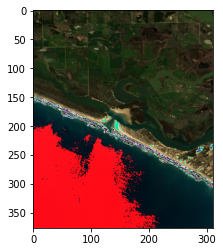

In [122]:
# Scale the data to [0, 255] to show as an RGB image.
rgb_img_test = (255*((rgb_img - 100)/3000)).astype('uint8')
plt.imshow(rgb_img_test)
plt.show()

In [143]:
# Convert numpy array to xarray
rgb_img_test.shape

(377, 311, 3)

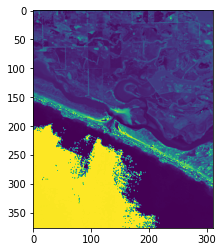

In [152]:
plt.imshow(rgb_img_test[:,:,0])
plt.show()

### Load GA data

In [190]:
#Load all data in baseline period available from Near Real Time data

wofs = dc.load(
              product=['wofs_annual_summary'],
              x= study_area_lon,
              y= study_area_lat,
              time=(start, end_ga),
              #measurements=['nbar_blue','nbar_green','nbar_red','nbar_nir_1', 'nbar_swir_3'],
              output_crs='EPSG:4326',
              crs='EPSG:4326',
              resolution=(-30, 30),
              #group_by='solar_day'
)

In [191]:
wofs

<xarray.Dataset>
Dimensions:      (latitude: 1, longitude: 1, time: 1)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01
  * latitude     (latitude) float64 -45.0
  * longitude    (longitude) float64 135.0
    spatial_ref  int32 4326
Data variables:
    count_wet    (time, latitude, longitude) int16 -1
    count_clear  (time, latitude, longitude) int16 -1
    frequency    (time, latitude, longitude) float32 -1.0
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5],
       dtype=float32),
 <a list of 10 Patch objects>)

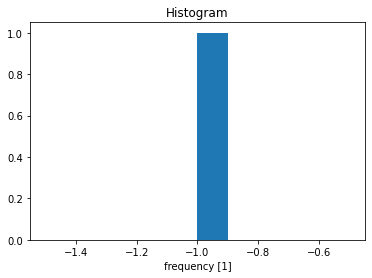

In [192]:
wofs.frequency.plot()

In [193]:
import xarray as xr

xr.DataArray(rgb_img_test,dims=())

ValueError: different number of dimensions on data and dims: 3 vs 0

In [170]:
wofs.squeeze(dim='time').coords

Coordinates:
    time         datetime64[ns] 2018-01-01
  * y            (y) float64 -3.895e+06 -3.895e+06 ... -3.906e+06 -3.906e+06
  * x            (x) float64 6.185e+05 6.185e+05 ... 6.281e+05 6.281e+05
    spatial_ref  int32 3577

In [189]:
wofs.coords['y']

<xarray.DataArray 'y' (y: 387)>
array([-3894885., -3894915., -3894945., ..., -3906405., -3906435., -3906465.])
Coordinates:
  * y            (y) float64 -3.895e+06 -3.895e+06 ... -3.906e+06 -3.906e+06
    spatial_ref  int32 3577
Attributes:
    units:       metre
    resolution:  -30.0
    crs:         EPSG:3577

In [188]:
wofs.coords['x']

<xarray.DataArray 'x' (x: 322)>
array([618495., 618525., 618555., ..., 628065., 628095., 628125.])
Coordinates:
  * x            (x) float64 6.185e+05 6.185e+05 ... 6.281e+05 6.281e+05
    spatial_ref  int32 3577
Attributes:
    units:       metre
    resolution:  30.0
    crs:         EPSG:3577

In [156]:
rgb_img_test[:,:,0].shape

(377, 311)

In [171]:
xr.DataArray(np_arr_b4[:,:,0],coords=wofs.squeeze(dim='time').coords)

ValueError: conflicting sizes for dimension 'y': length 311 on the data but length 387 on coordinate 'y'